In [11]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.autograd as auto
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import librosa
import matplotlib.pyplot as plt

In [12]:
data=joblib.load('mfcc.sav')
len(data)

X,y=[],[]
for i in data:
    X.append(librosa.util.pad_center(i[0], 173, axis=1))
    y.append(i[1])

y_dictionary={'air_conditioner':0,
              'car_horn':1,
              'children_playing':2,
              'dog_bark':3,
              'drilling':4,
              'engine_idling':5,
              'gun_shot':6,
              'jackhammer':7,
              'siren':8,
              'street_music':9}

for i in range(0,len(y)):
    y[i]=y_dictionary.get(y[i])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train[2].shape

(40, 173)

In [15]:
BATCH_SIZE = 64

In [16]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.Tensor(y_train)
y_test=torch.Tensor(y_test)

In [17]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

# test_ds = TensorDataset(X_test, y_test)
# test_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE * 2)

In [18]:
# parameters 
N_STEPS = 40
N_INPUTS = 173
N_NEURONS = 173
N_OUTPUTS = 10
N_EPHOCS = 10

In [19]:
class SoundRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(SoundRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        print(batch_size, n_steps, n_inputs, n_neurons, n_outputs)
        self.lstm = nn.LSTM(self.n_inputs, self.n_neurons,1)
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons),torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.lstm(X)  
        out = self.FC(lstm_out[-1])
        
        return out.view(-1, self.n_outputs) # batch_size X n_output


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SoundRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=5e-3)

def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

64 40 173 173 10


In [21]:
for_plot_loss=[]
for_plot_acc=[]
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        
        model.hidden = model.init_hidden() 
        
        inputs, labels = data
        inputs = inputs.view(-1, 40,173)

        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels.long(), BATCH_SIZE)
        
    for_plot_loss.append(train_running_loss/i)
    for_plot_acc.append(train_acc/i)
        
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 1.9637 | Train Accuracy: 27.75
Epoch:  1 | Loss: 1.4134 | Train Accuracy: 50.36
Epoch:  2 | Loss: 1.1534 | Train Accuracy: 60.84
Epoch:  3 | Loss: 0.9304 | Train Accuracy: 69.81
Epoch:  4 | Loss: 0.7519 | Train Accuracy: 76.16
Epoch:  5 | Loss: 0.6047 | Train Accuracy: 82.57
Epoch:  6 | Loss: 0.4859 | Train Accuracy: 86.45
Epoch:  7 | Loss: 0.3904 | Train Accuracy: 90.12
Epoch:  8 | Loss: 0.3109 | Train Accuracy: 92.90
Epoch:  9 | Loss: 0.2675 | Train Accuracy: 93.79


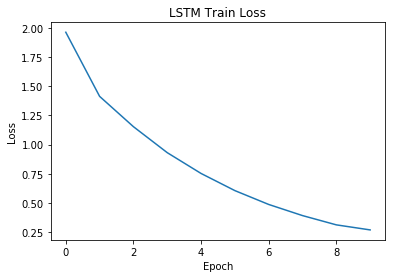

In [22]:
plt.plot(for_plot_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("LSTM Train Loss")
plt.show()

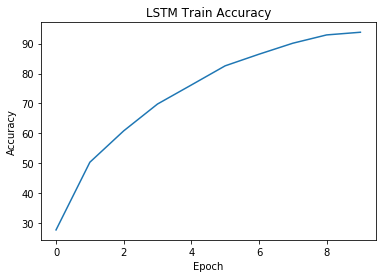

In [23]:
plt.plot(for_plot_acc)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("LSTM Train Accuracy")
plt.show()